In [3]:
import pandas as pd
import os, fnmatch

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [ ]:
scoresdf = pd.read_csv('Data/dicom/metadata_global_v2.csv')

In [ ]:
scoresdf

# Information needed:

### What size are images?  
 - Images are different sizes. We need to resize images to fit traditional deep learning models (256 x 256)

### What is s-global and j-global score  

### How will we judge similarity  

# TO DO:

### Need to seperate images and scores into train and test.  
   - Train should contain 80% of data made up of half covid positive and half non-covid OR equal representation of all scores
   - Test should be made of remaining scores but representative of population  
      
### Need to cut out center of images
   - Consider rotating if performance is bad
   
### Implement Keras CNN library for image classification

In [2]:
# getting all names of files that are in image folder


files = fnmatch.filter(os.listdir('Data\dicom\dicom_clean'), "*.dcm")

FileNotFoundError: [Errno 2] No such file or directory: 'Data\\dicom\\dicom_clean'

In [3]:
# Getting boolean values if filename is in DB and image folder
bool_df = scoresdf.Filename.isin(files)

NameError: name 'scoresdf' is not defined

In [4]:
# Taking out all files that are not in image folder so we only have scores for images we need
f_scoresdf = scoresdf[bool_df]

NameError: name 'scoresdf' is not defined

In [5]:
f_scoresdf

NameError: name 'f_scoresdf' is not defined

In [8]:
len(f_scoresdf) / len(scoresdf)
# Only using 7% of available images

0.07220447284345048

In [5]:
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Flatten, Dropout, Lambda, Concatenate
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard

from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D

import os
import numpy as np
import scipy
import skimage

import cv2

In [10]:
img = image.load_img('Data/dicom/dicom_clean/jpgs/img-00001-00001.jpg')

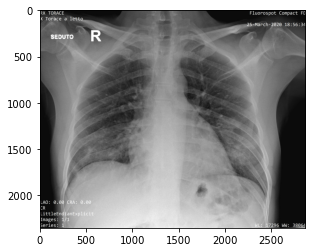

In [11]:
plt.imshow(img)

In [12]:
x = cv2.imread('Data/dicom/dicom_clean/jpgs/img-00001-00001.jpg', cv2.IMREAD_COLOR)

In [13]:
x = cv2.resize(x, (255, 255))
x = x/255.0
x = x.astype(np.float32)

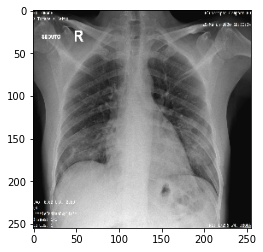

In [14]:
plt.imshow(x)

Loading data into environment

In [14]:
# load_data.py

import numpy as np
from skimage import transform, io, img_as_float, exposure

"""
Data was preprocessed in the following ways:
    - resize to im_shape;
    - equalize histogram (skimage.exposure.equalize_hist);
    - normalize by data set mean and std.
Resulting shape should be (n_samples, img_width, img_height, 1).
It may be more convenient to store preprocessed data for faster loading.
Dataframe should contain paths to images and masks as two columns (relative to `path`).
"""

def loadDataJSRT(df, path, im_shape):
    """This function loads data preprocessed with `preprocess_JSRT.py`"""
    X, y = [], []
    for i, item in df.iterrows():
        img = io.imread(path + item[0])
        img = transform.resize(img, im_shape)
        img = np.expand_dims(img, -1)
        mask = io.imread(path + item[1])
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print ('### Data loaded')
    print ('\t{}'.format(path))
    print ('\t{}\t{}'.format(X.shape, y.shape))
    print ('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print ('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y


def loadDataMontgomery(df, path, im_shape):
    """Function for loading Montgomery dataset"""
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        gt = io.imread(path + item[1])
        l, r = np.where(img.sum(0) > 1)[0][[0, -1]]
        t, b = np.where(img.sum(1) > 1)[0][[0, -1]]
        img = img[t:b, l:r]
        mask = gt[t:b, l:r]
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print ('### Data loaded')
    print ('\t{}'.format(path))
    print ('\t{}\t{}'.format(X.shape, y.shape))
    print ('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print ('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y


def loadDataGeneral(df, path, im_shape):
    """Function for loading arbitrary data in standard formats"""
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print ('### Dataset loaded')
    print ('\t{}'.format(path))
    print ('\t{}\t{}'.format(X.shape, y.shape))
    print ('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print ('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y

In [15]:
#build_model.py

def build_UNet2D_4L(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(data)
    conv1 = Convolution2D(filters=32, kernel_size=k_size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool1)
    conv2 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(pool2)
    conv3 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(pool3)
    conv4 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(pool4)

    up1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up1)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv6)
    merged1 = concatenate([conv4, conv6], axis=merge_axis)
    conv6 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged1)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(up2)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(conv7)
    merged2 = concatenate([conv3, conv7], axis=merge_axis)
    conv7 = Convolution2D(filters=256, kernel_size=k_size, padding='same', activation='relu')(merged2)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(up3)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(conv8)
    merged3 = concatenate([conv2, conv8], axis=merge_axis)
    conv8 = Convolution2D(filters=128, kernel_size=k_size, padding='same', activation='relu')(merged3)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(up4)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(conv9)
    merged4 = concatenate([conv1, conv9], axis=merge_axis)
    conv9 = Convolution2D(filters=64, kernel_size=k_size, padding='same', activation='relu')(merged4)

    conv10 = Convolution2D(filters=1, kernel_size=k_size, padding='same', activation='sigmoid')(conv9)

    output = conv10
    model = Model(data, output)
    return model

In [16]:
# image_gen.py
"""Fairly basic set of tools for real-time data augmentation on image data.
Can easily be extended to include new transformations,
new preprocessing methods, etc...
"""
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading
import warnings

from keras import backend as K

try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None


def random_rotation(x, rg, row_axis=1, col_axis=2, channel_axis=0,
                    fill_mode='nearest', cval=0.):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shift(x, wrg, hrg, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shift of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        wrg: Width shift range, as a float fraction of the width.
        hrg: Height shift range, as a float fraction of the height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Shifted Numpy image tensor.
    """
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = np.random.uniform(-hrg, hrg) * h
    ty = np.random.uniform(-wrg, wrg) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_shear(x, intensity, row_axis=1, col_axis=2, channel_axis=0,
                 fill_mode='nearest', cval=0.):
    """Performs a random spatial shear of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        intensity: Transformation intensity.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Sheared Numpy image tensor.
    """
    shear = np.random.uniform(-intensity, intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_zoom(x, zoom_range, row_axis=1, col_axis=2, channel_axis=0,
                fill_mode='nearest', cval=0.):
    """Performs a random spatial zoom of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        zoom_range: Tuple of floats; zoom range for width and height.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        Zoomed Numpy image tensor.
    # Raises
        ValueError: if `zoom_range` isn't a tuple.
    """
    if len(zoom_range) != 2:
        raise ValueError('zoom_range should be a tuple or list of two floats. '
                         'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x


def random_channel_shift(x, intensity, channel_axis=0):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])


def img_to_array(img, data_format=None):
    """Converts a PIL Image instance to a Numpy array.
    # Arguments
        img: PIL Image instance.
        data_format: Image data format.
    # Returns
        A 3D Numpy array.
    # Raises
        ValueError: if invalid `img` or `data_format` is passed.
    """
    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format: ', data_format)
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=K.floatx())
    if len(x.shape) == 3:
        if data_format == 'channels_first':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == 'channels_first':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError('Unsupported image shape: ', x.shape)
    return x


def load_img(path, grayscale=False, target_size=None):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size:
        hw_tuple = (target_size[1], target_size[0])
        if img.size != hw_tuple:
            img = img.resize(hw_tuple)
    return img


def list_pictures(directory, ext='jpg|jpeg|bmp|png'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f)]


class ImageDataGenerator(object):
    """Generate minibatches of image data with real-time data augmentation.
    # Arguments
        featurewise_center: set input mean to 0 over the dataset.
        samplewise_center: set each sample mean to 0.
        featurewise_std_normalization: divide inputs by std of the dataset.
        samplewise_std_normalization: divide each input by its std.
        zca_whitening: apply ZCA whitening.
        rotation_range: degrees (0 to 180).
        width_shift_range: fraction of total width.
        height_shift_range: fraction of total height.
        shear_range: shear intensity (shear angle in radians).
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range.
        channel_shift_range: shift range for each channels.
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'.
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally.
        vertical_flip: whether to randomly flip images vertically.
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run before any other modification on it.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: 'channels_first' or 'channels_last'. In 'channels_first' mode, the channels dimension
            (the depth) is at index 1, in 'channels_last' mode it is at index 3.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None):
        if data_format is None:
            data_format = K.image_data_format()
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('data_format should be "channels_last" (channel after row and '
                             'column) or "channels_first" (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('zoom_range should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_axis = self.channel_axis - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_axis, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_axis, keepdims=True) + 1e-7)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-7)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (x.size))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t'
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, y):
        """Randomly augment a single image tensor + image mask.
        # Arguments
            x: 3D tensor, single image.
            y: 3D tensor, image mask.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)
            y = apply_transform(y, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
            y = random_channel_shift(y,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)
                y = flip_axis(y, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)
                y = flip_axis(y, img_row_axis)

        return x, y

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits internal statistics to some sample data.
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
        # Arguments
            x: Numpy array, the data to fit on. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
            augment: Whether to fit on randomly augmented samples
            rounds: If `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Raises
            ValueError: in case of invalid input `x`.
        """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            raise ValueError(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]], _ = self.random_transform(x[i], x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())

        if self.zca_whitening:
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + 10e-7))), u.T)


class Iterator(object):
    """Abstract base class for image data iterators.
    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        if data_format is None:
            data_format = K.image_data_format()
        self.x = np.asarray(x, dtype=K.floatx())

        if self.x.ndim != 4:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 3 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            raise ValueError('NumpyArrayIterator is set to use the '
                             'data format convention "' + data_format + '" '
                             '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                             'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                             'However, it was passed an array with shape ' + str(self.x.shape) +
                             ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x_shape = [current_batch_size] + list(self.x.shape)[1:]
        batch_x_shape = tuple(batch_x_shape)
        batch_x = np.zeros(batch_x_shape, dtype=K.floatx())
        batch_y = np.zeros(tuple([current_batch_size] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            y = self.y[j]
            x, y = self.image_data_generator.random_transform(x.astype(K.floatx()), y.astype(K.floatx()))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = y

        if self.save_to_dir:
            for i in range(current_batch_size):
                imgx = array_to_img(batch_x[i], self.data_format, scale=True)
                imgy = array_to_img(batch_y[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                imgx.save(os.path.join(self.save_to_dir, 'x_' + fname))
                imgy.save(os.path.join(self.save_to_dir, 'y_' + fname))
        if self.y is None:
            return batch_x
        return batch_x, batch_y


In [18]:
#inference.py

import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, color, io, exposure

def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    boundary = morphology.dilation(gt, morphology.disk(3)) ^ gt
    color_mask[mask == 1] = [0, 0, 1]
    color_mask[boundary == 1] = [1, 0, 0]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = 'Data/dicom/masking/masknames'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = csv_path[:csv_path.rfind('/')] + '/'

    df = pd.read_csv('Data/dicom/masking/masknames2.csv')

    # Load test data
    im_shape = (256, 256)
    X, y = loadDataJSRT(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape

    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator is used.
    test_gen = ImageDataGenerator(rescale=1.)

    ious = np.zeros(n_test)
    dices = np.zeros(n_test)

    i = 0
    for xx, yy in test_gen.flow(X, y, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        mask = yy[..., 0].reshape(inp_shape[:2])

        # Binarize masks
        gt = mask > 0.5
        pr = pred > 0.5

        # Remove regions smaller than 2% of the image
        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        io.imsave('results/{}'.format(df.iloc[i][0]), masked(img, gt, pr, 1))

        ious[i] = IoU(gt, pr)
        dices[i] = Dice(gt, pr)
        print(df.iloc[i][0], ious[i], dices[i])

        i += 1
        if i == n_test:
            break

    print('Mean IoU:', ious.mean())
    print('Mean Dice:', dices.mean())

### Data loaded
	Data/dicom/masking/
	(3, 256, 256, 1)	(3, 256, 256, 1)
	X:-4.2-1.2	y:0.0-1.0

	X.mean = -5.921189464667501e-16, X.std = 1.0


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


2.jpg 0.965375834953919 0.9823825503355704


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3.jpg 0.9569927506719883 0.9780228928199792


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


4.jpg 0.9600936286823476 0.9796399860188745
Mean IoU: 0.9608207381027517
Mean Dice: 0.9800151430581415


In [21]:
# train_model.py

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint

if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = 'Data/dicom/masking/masknames2.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = csv_path[:csv_path.rfind('/')] + '/'

    df = pd.read_csv(csv_path)
    # Shuffle rows in dataframe. Random state is set for reproducibility.
    df = df.sample(frac=1, random_state=23)
    n_train = int(len(df))
    print('!!!!!!!!!!!!!!!!!!!!!!!')
    df_train = df[:n_train]
    df_val = df[n_train:]

    # Load training and validation data
    im_shape = (256, 256)
    X_train, y_train = loadDataJSRT(df_train, path, im_shape)
    X_val, y_val = loadDataJSRT(df_val, path, im_shape)

    # Build model
    inp_shape = X_train[0].shape
    UNet = build_UNet2D_4L(inp_shape)
    UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Visualize model
    plot_model(UNet, 'model.png', show_shapes=True)

    ##########################################################################################
    model_file_format = 'model.{epoch:03d}.hdf5'
    print(model_file_format)
    checkpointer = ModelCheckpoint(model_file_format, period=10)

    train_gen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

    test_gen = ImageDataGenerator(rescale=1.)

    batch_size = 8
    UNet.fit_generator(train_gen.flow(X_train, y_train, batch_size),
                       steps_per_epoch=(X_train.shape[0] + batch_size - 1) // batch_size,
                       epochs=100,
                       callbacks=[checkpointer],
                       validation_data=test_gen.flow(X_val, y_val),
                       validation_steps=(X_val.shape[0] + batch_size - 1) // batch_size)

!!!!!!!!!!!!!!!!!!!!!!!
### Data loaded
	Data/dicom/masking/
	(3, 256, 256, 1)	(3, 256, 256, 1)
	X:-4.2-1.2	y:0.0-1.0

	X.mean = -6.337523098901935e-16, X.std = 0.9999999999999998
### Data loaded
	Data/dicom/masking/
	(0,)	(0,)


<ipython-input-14-83a82621463f>:30: RuntimeWarning: Mean of empty slice.
  X -= X.mean()


ValueError: zero-size array to reduction operation minimum which has no identity

### Dataset loaded
	Data/dicom/masking/
	(3, 256, 256, 1)	(3, 256, 256, 1)
	X:-1.7-1.7	y:0.0-1.0

	X.mean = -2.544261098099317e-16, X.std = 0.9999999999999998
Mean IoU: 0.0
Mean Dice: 0.0


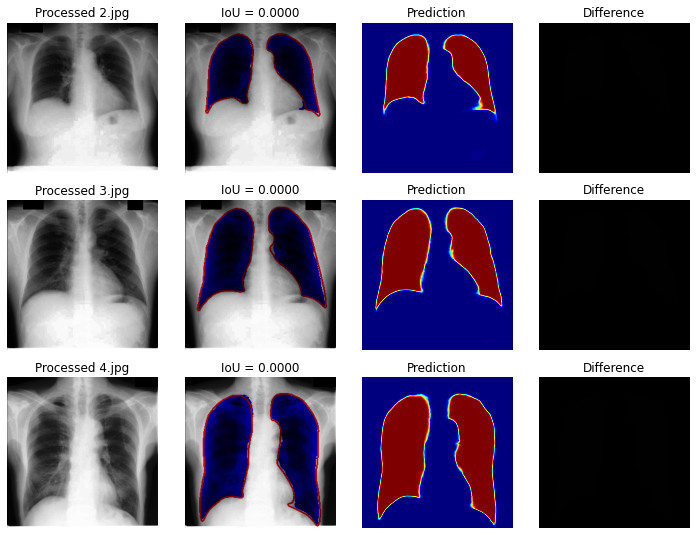

In [22]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from skimage import morphology, io, color, exposure, img_as_float, transform
from matplotlib import pyplot as plt

def loadDataGeneral(df, path, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        img = img_as_float(io.imread(path + item[0]))
        mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        mask = transform.resize(mask, im_shape)
        mask = np.expand_dims(mask, -1)
        X.append(img)
        y.append(mask)
    X = np.array(X)
    y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print ('### Dataset loaded')
    print ('\t{}'.format(path))
    print ('\t{}\t{}'.format(X.shape, y.shape))
    print ('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print ('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X, y

def IoU(y_true, y_pred):
    """Returns Intersection over Union score for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    """Returns Dice Similarity Coefficient for ground truth and predicted masks."""
    assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

def masked(img, gt, mask, alpha=1):
    """Returns image with GT lung field outlined with red, predicted lung field
    filled with blue."""
    rows, cols = img.shape
    color_mask = np.zeros((rows, cols, 3))
    boundary = morphology.dilation(gt, morphology.disk(3)) ^ gt
    color_mask[mask == 1] = [0, 0, 1]
    color_mask[boundary == 1] = [1, 0, 0]
    img_color = np.dstack((img, img, img))

    img_hsv = color.rgb2hsv(img_color)
    color_mask_hsv = color.rgb2hsv(color_mask)

    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha

    img_masked = color.hsv2rgb(img_hsv)
    return img_masked

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

if __name__ == '__main__':

    # Path to csv-file. File should contain X-ray filenames as first column,
    # mask filenames as second column.
    csv_path = 'Data/dicom/masking/masknames2.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    path = 'Data/dicom/masking/'

    df = pd.read_csv(csv_path)

    # Load test data
    im_shape = (256, 256)
    X, y = loadDataGeneral(df, path, im_shape)

    n_test = X.shape[0]
    inp_shape = X[0].shape

    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)

    ious = np.zeros(n_test)
    dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    plt.figure(figsize=(10, 10))
    for xx, yy in test_gen.flow(X, y, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        mask = yy[..., 0].reshape(inp_shape[:2])

        gt = mask > 0.5
        pr = pred > 0.5

        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        gts.append(gt)
        prs.append(pr)
        #ious[i] = IoU(gt, pr)
        #dices[i] = Dice(gt, pr)
        #print(df.iloc[i][0], ious[i], dices[i])

        if i < 4:
            plt.subplot(4, 4, 4*i+1)
            plt.title('Processed ' + df.iloc[i][0])
            plt.axis('off')
            plt.imshow(img, cmap='gray')

            plt.subplot(4, 4, 4 * i + 2)
            plt.title('IoU = {:.4f}'.format(ious[i]))
            plt.axis('off')
            plt.imshow(masked(img, gt, pr, 1))

            plt.subplot(4, 4, 4*i+3)
            plt.title('Prediction')
            plt.axis('off')
            plt.imshow(pred, cmap='jet')

            plt.subplot(4, 4, 4*i+4)
            plt.title('Difference')
            plt.axis('off')
            plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i += 1
        if i == n_test:
            break

    print('Mean IoU:', ious.mean())
    print('Mean Dice:', dices.mean())
    plt.tight_layout()
    plt.savefig('results.png')
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
### Dataset loaded
	Data/public-cohen-subset/
	X.mean = -2.735417987799317e-15, X.std = 1.0000000000000004


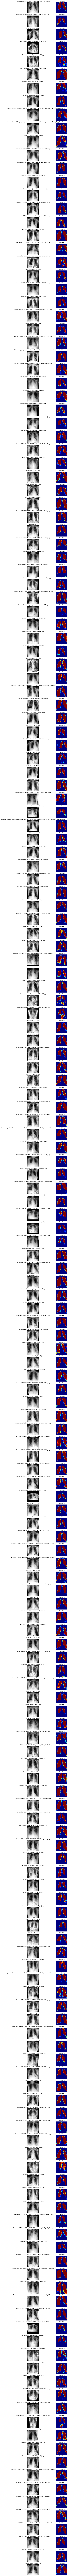

In [42]:
#doing lung segmintation on big data set with no mask
import cv2


def loadDataGeneralField(df, path, im_shape):
    X, y = [], []
    for i, item in df.iterrows():
        print(i)
        img = img_as_float(cv2.imread(path + item[0]))
        #mask = io.imread(path + item[1])
        img = transform.resize(img, im_shape)
        img = exposure.equalize_hist(img)
        img = np.expand_dims(img, -1)
        #mask = transform.resize(mask, im_shape)
        #mask = np.expand_dims(mask, -1)
        X.append(img)
        #y.append(mask)
    X = np.array(X)
    #y = np.array(y)
    X -= X.mean()
    X /= X.std()

    print ('### Dataset loaded')
    print ('\t{}'.format(path))
    #print ('\t{}\t{}'.format(X.shape, y.shape))
    #print ('\tX:{:.1f}-{:.1f}\ty:{:.1f}-{:.1f}\n'.format(X.min(), X.max(), y.min(), y.max()))
    print ('\tX.mean = {}, X.std = {}'.format(X.mean(), X.std()))
    return X


if __name__ == '__main__':
    
    # Path to csv-file. File should contain X-ray filenames as first column,
    csv_pathField = 'Data/public-annotations.csv'
    # Path to the folder with images. Images will be read from path + path_from_csv
    pathField = 'Data/public-cohen-subset/'

    dfField = pd.read_csv(csv_pathField)
    
    # Load field data
    im_shapeField = (256, 256)
    X = loadDataGeneralField(dfField, pathField, im_shapeField)

    n_test = X.shape[0]
    inp_shape = X[0].shape
    
    # Load model
    model_name = 'trained_model.hdf5'
    UNet = load_model(model_name)

    # For inference standard keras ImageGenerator can be used.
    test_gen = ImageDataGenerator(rescale=1.)
    
    
    #ious = np.zeros(n_test)
    #dices = np.zeros(n_test)

    gts, prs = [], []
    i = 0
    X = X[:,:,:,0]
    plt.figure(figsize=(10, 500))
    for xx, yy in test_gen.flow(X, X, batch_size=1):
        img = exposure.rescale_intensity(np.squeeze(xx), out_range=(0,1))
        pred = UNet.predict(xx)[..., 0].reshape(inp_shape[:2])
        #mask = yy[..., 0].reshape(inp_shape[:2])

        #gt = mask > 0.5
        pr = pred > 0.5

        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))

        #io.imsave('{}'.format(df.iloc[i].path), masked(img, gt, pr, 1))

        #gts.append(gt)
        prs.append(pr)
        #ious[i] = IoU(gt, pr)
        #dices[i] = Dice(gt, pr)
        #print(df.iloc[i][0], ious[i], dices[i])

        if i < n_test:
            plt.subplot(n_test, 2, 2*i+1)
            plt.title('Processed ' + df.iloc[i][0])
            plt.axis('off')
            plt.imshow(img, cmap='gray')

            #plt.subplot(4, 4, 4 * i + 2)
            #plt.title('IoU = {:.4f}'.format(ious[i]))
            #plt.axis('off')
            #plt.imshow(masked(img, gt, pr, 1))

            plt.subplot(n_test, 2, 2*i+2)
            plt.title('Prediction')
            plt.axis('off')
            plt.imshow(pred, cmap='jet')

            #plt.subplot(4, 4, 4*i+4)
            #plt.title('Difference')
            #plt.axis('off')
            #plt.imshow(np.dstack((pr.astype(np.int8), gt.astype(np.int8), pr.astype(np.int8))))

        i += 1
        if i == n_test:
            break

    #print('Mean IoU:', ious.mean())
    #print('Mean Dice:', dices.mean())
    #plt.tight_layout()
    plt.savefig('results.png')
    plt.show()
    
    




In [53]:
print (n_test)
print (len(prs[1]))

192
256
